In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from sklearn import preprocessing

%matplotlib inline

### Import Crime Rates

In [2]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')

df = pd.read_sql_query("select * from all_crimes", conn)

conn.close()

### Standardize Crime Rates

Set variable for standardization

In [3]:
standardize = df[['crime_rate']]

Standardize using [Power Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer) from Scikit Learn library.

In [4]:
power = preprocessing.PowerTransformer(method='box-cox', standardize=False)
standardize['crs'] = power.fit_transform(standardize)

C:\Users\Barbieri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Plot Before and After

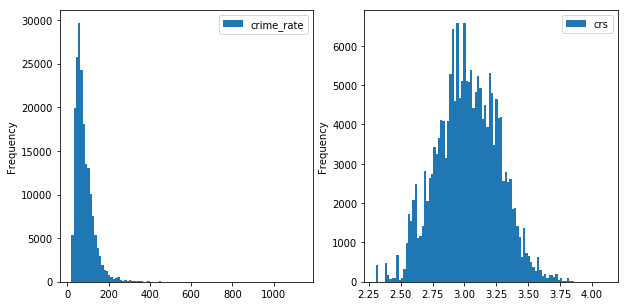

In [5]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

standardize[['crime_rate']].plot(kind='hist', ax=ax1, bins=100)
standardize[['crs']].plot(kind='hist', ax=ax2, bins=100)

### Classify Crime Rates

$ High = SCR \geq \mu + 2\sigma $  
$ Medium-High = \mu + \sigma \leq SCR \lt \mu + 2\sigma $  
$ Medium = \mu - \sigma \leq SCR \lt \mu + \sigma $  
$ Medium-Low = \mu - 2\sigma \leq SCR \lt \mu - \sigma $  
$ Low = SCR \lt \mu - 2\sigma $

In [6]:
def classifyCrimeRates(crime_rates, stats):
    '''
    Classify crime rates based on standardized crime rate values.
    '''
    range_high = float(stats['mean'] + 2*stats['std'])
    range_low = float(stats['mean'] - 2*stats['std'])
    range_mid_high = float(stats['mean'] + stats['std'])
    range_mid_low = float(stats['mean'] - stats['std'])
    cr = float(crime_rates['crs'])

    if cr >= range_high:
        crime_rate_cat = 'High'
    if cr >= range_mid_high and cr < range_high:
        crime_rate_cat = 'Med-High'
    if cr >= range_mid_low and cr < range_mid_high:
        crime_rate_cat = 'Med'
    if cr >= range_low and cr < range_mid_low:
        crime_rate_cat = 'Low-Med'
    if cr < range_low:
        crime_rate_cat = 'Low'

    return crime_rate_cat

In [7]:
stats = df[['crs']].describe().transpose()

In [8]:
df['crime_rate_cat'] = df[['crs']].apply(classifyCrimeRates, args=(stats[['mean','std']],), axis=1)

In [ ]:
df['crime_rate_cat'].value_counts().reindex(index=['Low','Low-Med','Med','Med-High','High']).plot(kind='bar', ax=ax1)